In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sys
import astropy.units as u
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda

sys.path.insert(0, '../')
from libra import Spot, Star

(array([   358.,   3555.,  10789.,  31006.,  41221.,  35306.,  18638.,
         11128.,   5553.,   2446.]),
 array([ 4586.81959402,  4728.68312115,  4870.54664828,  5012.41017542,
         5154.27370255,  5296.13722968,  5438.00075682,  5579.86428395,
         5721.72781109,  5863.59133822,  6005.45486535]),
 <a list of 10 Patch objects>)

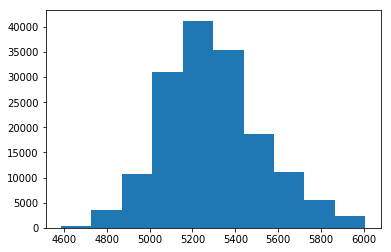

In [3]:
kepler_contrast, temperatures_tested = np.loadtxt('contrast_to_temperature.txt', unpack=True)

samples = np.loadtxt('posteriors_bright_spot.txt')

temperature_samples = np.interp(samples[:, -2], kepler_contrast, temperatures_tested)

typical_spot_radius = np.median(samples[:, 2])

spot_temperature = np.median(temperature_samples)

plt.hist(temperature_samples)

#plt.plot(kepler_contrast, temperatures_tested)
#plt.grid()
#plt.xlabel('Kepler spot contrast')
#plt.ylabel('temp')
#plt.savefig('kepler_spitzer_contrasts.png', dpi=200)

In [4]:
typical_spot_radius

0.0059925038535171612

In [5]:
from glob import glob

paths = glob('/Users/bmmorris/git/freckles/data/lte*BT-Settl.spec.fits')

from astropy.io import fits

wavelengths = fits.getdata(paths[0])['Wavelength']

temperatures = []
model_fluxes = []

for path in paths:
    hdu = fits.open(path)
    temperatures.append(hdu[1].header['PHXTEFF'])
    interp_flux = np.interp(wavelengths, hdu[1].data['Wavelength'], hdu[1].data['Flux'])
    model_fluxes.append(interp_flux)
    
model_fluxes = np.vstack(model_fluxes)
temperatures = np.array(temperatures)

In [6]:
trappist1_flux = model_fluxes[np.argmin(np.abs(temperatures-2500)), :] * wavelengths
hotspot_flux = model_fluxes[np.argmin(np.abs(temperatures-spot_temperature)), :] * wavelengths

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


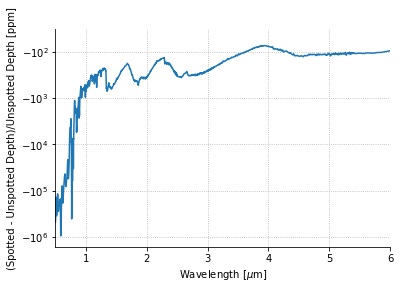

In [7]:
from scipy.ndimage import gaussian_filter1d

c = gaussian_filter1d(hotspot_flux/trappist1_flux, 500)
depth_ratio = 1 + (c - 1) * typical_spot_radius**2

depth_correction_percent = 1e6 * (1/depth_ratio - 1)

plt.plot(wavelengths, depth_correction_percent)
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('(Spotted - Unspotted Depth)/Unspotted Depth [ppm]')
plt.xlim([0.5, 6])
#plt.ylim([0.8, 1.1])
#plt.ylim([0, 1000])

# plt.ylim([-0.1, 0])
ax = plt.gca()
ax.set_yscale('symlog')
#ax.invert_yaxis()
plt.grid(ls=':')

#ax.set_yticklabels(["{0}".format(l) for l in ax.get_yticklabels()])

s = "$T_\mathrm{{phot}} = 2500$ K\n$T_\mathrm{{spot}} = {0:.0f}$ K".format(temperatures[np.argmin(np.abs(temperatures-spot_temperature))])
#plt.annotate(s, xy=(4, 600), fontsize=14)

ax = plt.gca()
for i in ['right', 'top']:
    ax.spines[i].set_visible(False)
plt.savefig('transmission_spectrum.pdf', bbox_inches='tight')
np.savetxt('bright_spot_contamination.txt', np.vstack([wavelengths, depth_correction_percent]).T)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


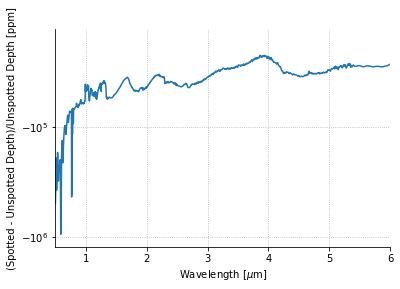

In [12]:
trappist1_flux = model_fluxes[np.argmin(np.abs(temperatures-2500)), :] * wavelengths
hotspot_flux = model_fluxes[np.argmin(np.abs(temperatures-spot_temperature)), :] * wavelengths
darkspot_flux = model_fluxes[np.argmin(np.abs(temperatures-2000)), :] * wavelengths

from scipy.ndimage import gaussian_filter1d

c = gaussian_filter1d(hotspot_flux/trappist1_flux, 500)
c2 = gaussian_filter1d(darkspot_flux/trappist1_flux, 500)
depth_ratio = 1 + (c - 1) * typical_spot_radius**2 - 0.08 * (c2 - 1)

depth_correction_percent = 1e6 * (1/depth_ratio - 1)

plt.plot(wavelengths, depth_correction_percent)
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('(Spotted - Unspotted Depth)/Unspotted Depth [ppm]')
plt.xlim([0.5, 6])
#plt.ylim([0.8, 1.1])
#plt.ylim([0, 1000])

# plt.ylim([-0.1, 0])
ax = plt.gca()
ax.set_yscale('symlog')
#ax.invert_yaxis()
plt.grid(ls=':')

#ax.set_yticklabels(["{0}".format(l) for l in ax.get_yticklabels()])

s = "$T_\mathrm{{phot}} = 2500$ K\n$T_\mathrm{{spot}} = {0:.0f}$ K".format(temperatures[np.argmin(np.abs(temperatures-spot_temperature))])
#plt.annotate(s, xy=(4, 600), fontsize=14)

ax = plt.gca()
for i in ['right', 'top']:
    ax.spines[i].set_visible(False)
plt.savefig('transmission_spectrum_bright_and_dark.pdf', bbox_inches='tight')
#np.savetxt('bright_and_dark_spot_contamination.txt', np.vstack([wavelengths, depth_correction_percent]).T)